working on a new model, an improved FSM

In [1]:
import os
import sys
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DBNAME = "king_county_housing_prices"
conn = psycopg2.connect(dbname=DBNAME)

In [6]:
data = pd.read_sql("""
            SELECT DISTINCT
                   rps.major
                   ,rps.minor
                   ,rps.documentdate :: date
                   ,rps.saleprice
                   ,rb.zipcode
                   ,rb.stories
                   ,rb.buildinggrade
                   ,rb.squarefeettotalliving
                   ,rb.squarefeettotalbasement
                   ,rb.squarefeetopenporch
                   ,rb.squarefeetenclosedporch
                   ,rb.squarefeetdeck
                   ,p.township
                   ,p.districtname
                   ,p.lotsquarefootage
                   ,p.streetsurface
                   ,p.restrictivesizeshape
                   ,p.inadequateparking
                   ,p.percentunusable
                   ,p.waterfrontlocation
                   ,p.trafficnoise
                   ,p.airportnoise
                   ,p.powerlines
                   ,p.othernuisances
            FROM real_property_sales rps
            JOIN residential_building rb 
                 ON rb.major = rps.major
                 AND rb.minor = rps.minor
            JOIN parcel p 
                 ON p.major = rps.major
                 AND p.minor = rps.minor
            WHERE (rps.propertytype = '12' OR rps.propertytype = '14' OR rps.propertytype = '18' OR rps.propertytype = '11')
                        AND (rps.principaluse = '2' OR rps.principaluse = '6')
                        AND (rps.documentdate > '2018-12-31' and rps.documentdate < '2020-01-01')
                        AND (rb.squarefeettotalliving > 800 AND rb.squarefeettotalliving  < 4500)
                        AND (rps.saleprice > 10.00 AND rps.saleprice < 2500000)
                   """,conn)

In [7]:
data.head()

,major,minor,documentdate,saleprice,zipcode,stories,buildinggrade,squarefeettotalliving,squarefeettotalbasement,squarefeetopenporch,...,lotsquarefootage,streetsurface,restrictivesizeshape,inadequateparking,percentunusable,waterfrontlocation,trafficnoise,airportnoise,powerlines,othernuisances
0,000100,0042,2019-10-29,485500.0,,2.0,7.0,2134.0,0.0,244.0,...,6002.0,1.0,0.0,2.0,0.0,0,0,0,0,N
1,000100,0067,2019-03-18,358308.0,98002,1.0,8.0,2240.0,1340.0,170.0,...,17400.0,1.0,0.0,2.0,0.0,0,0,0,0,N
2,000120,0008,2019-05-17,850000.0,98166,1.0,8.0,3500.0,1750.0,0.0,...,24142.0,1.0,0.0,0.0,0.0,0,0,0,0,N
3,000200,0015,2019-11-19,465000.0,98032,1.0,8.0,2360.0,1130.0,80.0,...,15405.0,1.0,0.0,0.0,0.0,0,0,1,0,N
4,000300,0086,2019-06-18,350000.0,98168,1.0,6.0,1240.0,750.0,0.0,...,9200.0,2.0,0.0,2.0,0.0,0,0,0,0,N


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17759 entries, 0 to 17758
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   major                    17759 non-null  object 
 1   minor                    17759 non-null  object 
 2   documentdate             17759 non-null  object 
 3   saleprice                17759 non-null  float64
 4   zipcode                  17759 non-null  object 
 5   stories                  17759 non-null  float64
 6   buildinggrade            17759 non-null  float64
 7   squarefeettotalliving    17759 non-null  float64
 8   squarefeettotalbasement  17759 non-null  float64
 9   squarefeetopenporch      17759 non-null  float64
 10  squarefeetenclosedporch  17759 non-null  float64
 11  squarefeetdeck           17759 non-null  float64
 12  township                 17759 non-null  float64
 13  districtname             17759 non-null  object 
 14  lotsquarefootage      

In [9]:
data.describe()

,saleprice,stories,buildinggrade,squarefeettotalliving,squarefeettotalbasement,squarefeetopenporch,squarefeetenclosedporch,squarefeetdeck,township,lotsquarefootage,streetsurface,restrictivesizeshape,inadequateparking,percentunusable
count,1.775900e+04,17759.000000,17759.000000,17759.000000,17759.000000,17759.000000,17759.000000,17759.000000,17759.000000,17759.000000,17759.000000,17759.000000,17759.000000,17759.000000
mean,7.361805e+05,1.562250,7.651726,2084.623121,467.844530,67.354299,5.236612,132.654372,23.795766,14373.049721,1.016048,0.002984,1.242863,0.003379
std,3.698337e+05,0.558188,1.037774,786.706331,554.084372,137.841272,35.189892,204.515212,1.686792,36489.020927,0.190498,0.054550,0.969623,0.321175
min,1.000000e+03,1.000000,4.000000,804.000000,0.000000,0.000000,0.000000,0.000000,19.000000,458.000000,0.000000,0.000000,0.000000,0.000000
25%,4.700000e+05,1.000000,7.000000,1470.000000,0.000000,0.000000,0.000000,0.000000,22.000000,5000.000000,1.000000,0.000000,0.000000,0.000000
50%,6.500000e+05,2.000000,7.000000,1960.000000,0.000000,0.000000,0.000000,0.000000,24.000000,7500.000000,1.000000,0.000000,2.000000,0.000000
75%,8.815065e+05,2.000000,8.000000,2570.000000,940.000000,90.000000,0.000000,210.000000,25.000000,10433.500000,1.000000,0.000000,2.000000,0.000000
max,2.498000e+06,4.000000,12.000000,4490.000000,3100.000000,11570.000000,1840.000000,2250.000000,26.000000,897336.000000,4.000000,1.000000,2.000000,34.000000


more graphs 

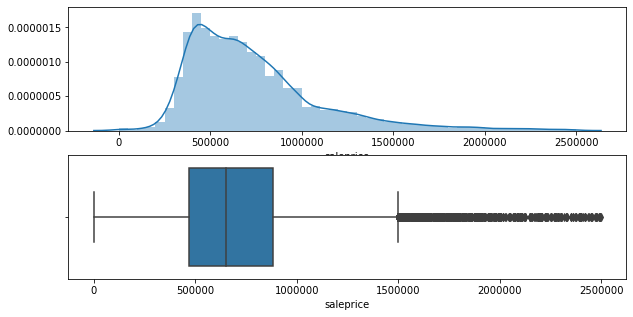

In [10]:
fig, ax = plt.subplots(2,1, figsize=(10,5))
sns.distplot(data.saleprice, ax = ax[0])
sns.boxplot(data.saleprice, ax= ax[1]);

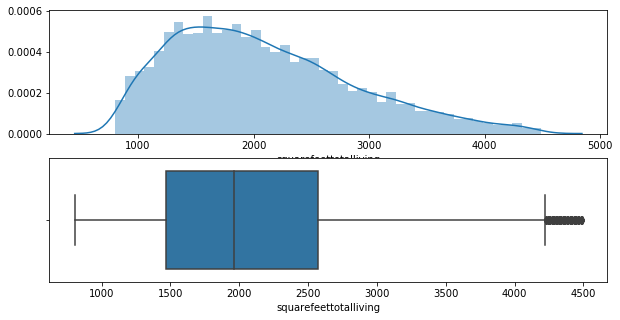

In [11]:
fig, ax = plt.subplots(2,1, figsize=(10,5))
sns.distplot(data.squarefeettotalliving, ax = ax[0])
sns.boxplot(data.squarefeettotalliving, ax= ax[1]);

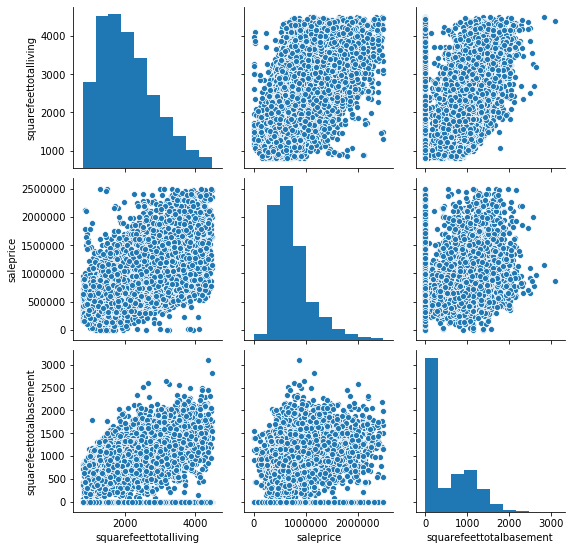

In [12]:
sns.pairplot(data = data[['squarefeettotalliving','saleprice','squarefeettotalbasement']])

In [13]:
data.corr()

,saleprice,stories,buildinggrade,squarefeettotalliving,squarefeettotalbasement,squarefeetopenporch,squarefeetenclosedporch,squarefeetdeck,township,lotsquarefootage,streetsurface,restrictivesizeshape,inadequateparking,percentunusable
saleprice,1.000000,0.280741,0.617832,0.594220,0.218695,0.202050,0.007280,0.198276,0.462660,0.055835,-0.027165,0.013471,0.055621,0.014217
stories,0.280741,1.000000,0.431771,0.329739,-0.275783,0.141882,-0.004379,0.000826,0.086321,-0.035185,-0.045672,0.017016,0.065862,-0.010597
buildinggrade,0.617832,0.431771,1.000000,0.692372,0.021491,0.216453,-0.028747,0.187775,0.150771,0.071046,-0.023284,0.011398,0.037277,0.012316
squarefeettotalliving,0.594220,0.329739,0.692372,1.000000,0.225968,0.287807,-0.024634,0.197550,0.053382,0.132054,0.004954,0.014664,0.004249,0.017567
squarefeettotalbasement,0.218695,-0.275783,0.021491,0.225968,1.000000,-0.066900,0.011535,0.250663,0.177949,-0.017422,-0.011528,-0.015996,-0.016539,0.012312
squarefeetopenporch,0.202050,0.141882,0.216453,0.287807,-0.066900,1.000000,-0.018827,-0.036314,-0.028879,0.152541,0.064682,0.018612,0.006403,0.013303
squarefeetenclosedporch,0.007280,-0.004379,-0.028747,-0.024634,0.011535,-0.018827,1.000000,0.016893,0.009221,0.032862,0.004675,0.005646,0.002920,-0.001565
squarefeetdeck,0.198276,0.000826,0.187775,0.197550,0.250663,-0.036314,0.016893,1.000000,0.062951,0.115598,0.064557,0.006710,0.002688,-0.006824
township,0.462660,0.086321,0.150771,0.053382,0.177949,-0.028879,0.009221,0.062951,1.000000,-0.101174,-0.060950,0.020089,0.017038,0.013747
lotsquarefootage,0.055835,-0.035185,0.071046,0.132054,-0.017422,0.152541,0.032862,0.115598,-0.101174,1.000000,0.302163,0.060351,-0.000261,0.001305


In [15]:
from statsmodels.formula.api import ols
fsm_df = data[['squarefeettotalliving','saleprice','buildinggrade','township']]
fsm_df.head()


,squarefeettotalliving,saleprice,buildinggrade,township
0,2134.0,485500.0,7.0,21.0
1,2240.0,358308.0,8.0,21.0
2,3500.0,850000.0,8.0,23.0
3,2360.0,465000.0,8.0,22.0
4,1240.0,350000.0,6.0,23.0


In [19]:
formula = 'squarefeettotalliving~saleprice'
fsm = ols(formula=formula, data=fsm_df).fit()

In [17]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     squarefeettotalliving   R-squared:                       0.353
Model:                               OLS   Adj. R-squared:                  0.353
Method:                    Least Squares   F-statistic:                     9692.
Date:                   Tue, 16 Jun 2020   Prob (F-statistic):               0.00
Time:                           18:30:21   Log-Likelihood:            -1.3975e+05
No. Observations:                  17759   AIC:                         2.795e+05
Df Residuals:                      17757   BIC:                         2.795e+05
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1154.0782     10.578    109.105      0.000    1133.345    1174.811
saleprice      0.0013   1.28e-05     98.449      0.000       0.001       0.001
==============================================================================
Omnibus:                      571.088   Durbin-Watson:                   1.202
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              632.313
Skew:                           0.439   Prob(JB):                    4.95e-138
Kurtosis:                       3.289   Cond. No.                     1.84e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
rsquared = fsm.rsquared
params = fsm.params

print(f'Rsquared of FSM: {rsquared}')
print('----------')
print('Beta values of FSM:')
print(params)

Rsquared of FSM: 0.3530968243340302
----------
Beta values of FSM:
Intercept    1154.078176
saleprice       0.001264
dtype: float64


In [21]:
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

rainbow_statistic, rainbow_p_value = linear_rainbow(fsm)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0623431956634102
Rainbow p-value: 0.002193225204702598


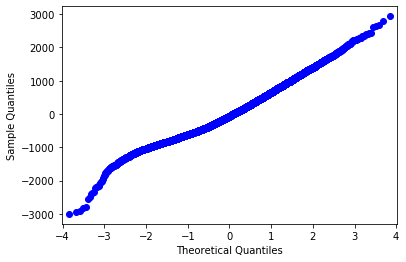

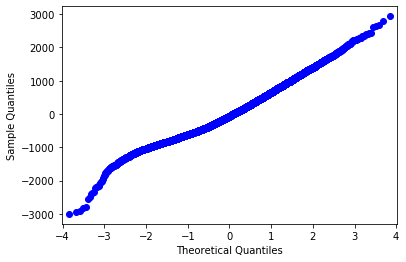

In [22]:
fsm_resids = fsm.resid
import statsmodels.api as sm
sm.qqplot(fsm_resids)

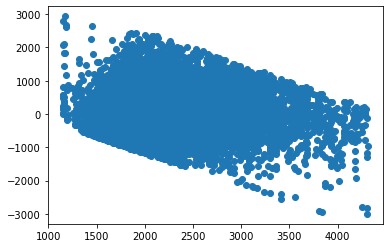

In [23]:
y_hat = fsm.predict()
plt.scatter(y_hat,fsm_resids)
plt.show()

better, try again

In [24]:
formula = 'saleprice ~ squarefeettotalliving + buildinggrade'
fsm = ols(formula=formula, data=fsm_df).fit()

In [25]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     6833.
Date:                Tue, 16 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:38:31   Log-Likelihood:            -2.4781e+05
No. Observations:               17759   AIC:                         4.956e+05
Df Residuals:                   17756   BIC:                         4.957e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -6.583e+05   1.71e+04    -38.562      0.000   -6.92e+05   -6.25e+05
squarefeettotalliving   150.2990      3.675     40.893      0.000     143.095     157.503
buildinggrade          1.413e+05   2786.252     50.710      0.000    1.36e+05    1.47e+05
==============================================================================
Omnibus:                     3553.520   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9868.464
Skew:                           1.066   Prob(JB):                         0.00
Kurtosis:                       5.965   Cond. No.                     1.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
rsquared = fsm.rsquared
params = fsm.params

print(f'Rsquared of FSM: {rsquared}')
print('----------')
print('Beta values of FSM:')
print(params)

Rsquared of FSM: 0.4349326377327044
----------
Beta values of FSM:
Intercept               -658256.463199
squarefeettotalliving       150.298951
buildinggrade            141291.037216
dtype: float64


In [27]:
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

rainbow_statistic, rainbow_p_value = linear_rainbow(fsm)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0585848477823363
Rainbow p-value: 0.003659857396616593


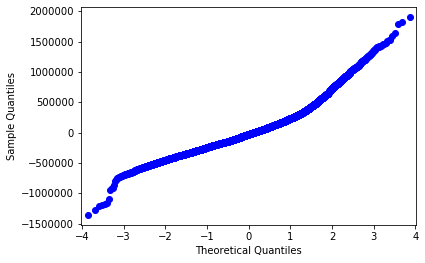

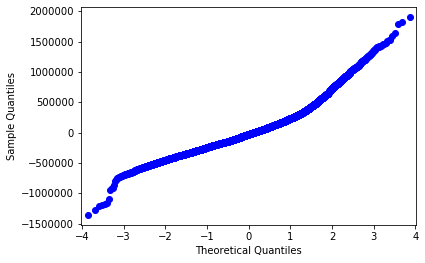

In [28]:
fsm_resids = fsm.resid

import statsmodels.api as sm
sm.qqplot(fsm_resids)

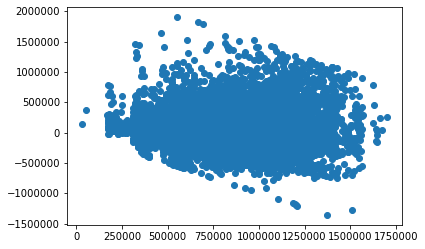

In [29]:
y_hat = fsm.predict()
plt.scatter(y_hat,fsm_resids)
plt.show()

In [30]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(fsm_resids, fsm_df[["squarefeettotalliving"]])
print("Lagrange Multiplier p-value:", lm_p_value)
print("F-statistic p-value:", f_p_value)

Lagrange Multiplier p-value: nan
F-statistic p-value: 0.0


In [33]:
data.drop_duplicates()

,major,minor,documentdate,saleprice,zipcode,stories,buildinggrade,squarefeettotalliving,squarefeettotalbasement,squarefeetopenporch,...,lotsquarefootage,streetsurface,restrictivesizeshape,inadequateparking,percentunusable,waterfrontlocation,trafficnoise,airportnoise,powerlines,othernuisances
0,000100,0042,2019-10-29,485500.0,,2.0,7.0,2134.0,0.0,244.0,...,6002.0,1.0,0.0,2.0,0.0,0,0,0,0,N
1,000100,0067,2019-03-18,358308.0,98002,1.0,8.0,2240.0,1340.0,170.0,...,17400.0,1.0,0.0,2.0,0.0,0,0,0,0,N
2,000120,0008,2019-05-17,850000.0,98166,1.0,8.0,3500.0,1750.0,0.0,...,24142.0,1.0,0.0,0.0,0.0,0,0,0,0,N
3,000200,0015,2019-11-19,465000.0,98032,1.0,8.0,2360.0,1130.0,80.0,...,15405.0,1.0,0.0,0.0,0.0,0,0,1,0,N
4,000300,0086,2019-06-18,350000.0,98168,1.0,6.0,1240.0,750.0,0.0,...,9200.0,2.0,0.0,2.0,0.0,0,0,0,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17754,984230,0625,2019-09-25,620000.0,98126,1.0,7.0,1010.0,0.0,0.0,...,4112.0,1.0,0.0,0.0,0.0,0,0,0,0,N
17755,984230,0690,2019-07-22,849950.0,,2.0,9.0,2620.0,970.0,390.0,...,4149.0,1.0,0.0,0.0,0.0,0,0,0,0,N
17756,988820,0010,2019-12-17,510000.0,98055,2.0,7.0,1820.0,0.0,10.0,...,5352.0,1.0,0.0,2.0,0.0,0,0,1,0,N
17757,990000,0470,2019-06-06,1275000.0,98166,3.0,9.0,3830.0,0.0,130.0,...,6182.0,1.0,0.0,2.0,0.0,0,0,1,0,N


In [34]:
newsm_df = data[['squarefeettotalliving','saleprice','buildinggrade','township','lotsquarefootage']]
newsm_df.head()

,squarefeettotalliving,saleprice,buildinggrade,township,lotsquarefootage
0,2134.0,485500.0,7.0,21.0,6002.0
1,2240.0,358308.0,8.0,21.0,17400.0
2,3500.0,850000.0,8.0,23.0,24142.0
3,2360.0,465000.0,8.0,22.0,15405.0
4,1240.0,350000.0,6.0,23.0,9200.0


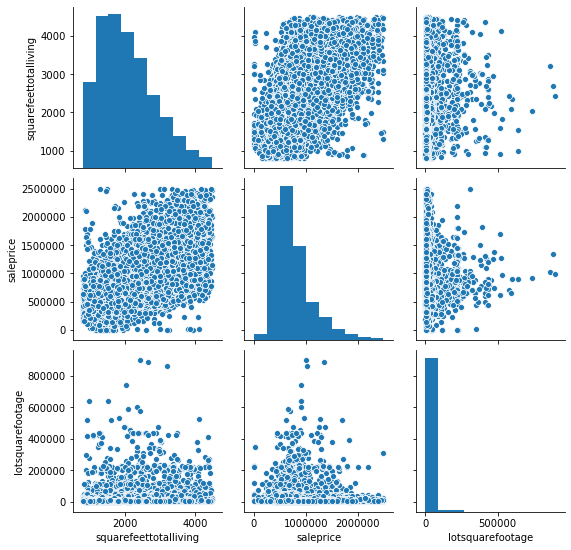

In [35]:
sns.pairplot(data = data[['squarefeettotalliving','saleprice','lotsquarefootage']])

In [37]:
formula = 'saleprice ~ squarefeettotalliving + lotsquarefootage'
newsm = ols(formula=formula, data=newsm_df).fit()

In [38]:
newsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     4857.
Date:                Tue, 16 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:54:45   Log-Likelihood:            -2.4901e+05
No. Observations:               17759   AIC:                         4.980e+05
Df Residuals:                   17756   BIC:                         4.980e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.542e+05   6320.596     24.401      0.000    1.42e+05    1.67e+05
squarefeettotalliving   280.7749      2.861     98.123      0.000     275.166     286.384
lotsquarefootage         -0.2335      0.062     -3.784      0.000      -0.354      -0.113
==============================================================================
Omnibus:                     3328.486   Durbin-Watson:                   0.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8275.289
Skew:                           1.041   Prob(JB):                         0.00
Kurtosis:                       5.618   Cond. No.                     1.11e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
rsquared = newsm.rsquared
params = newsm.params

print(f'Rsquared of newSM: {rsquared}')
print('----------')
print('Beta values of newSM:')
print(params)

Rsquared of newSM: 0.3536182092335979
----------
Beta values of newSM:
Intercept                154226.345308
squarefeettotalliving       280.774934
lotsquarefootage             -0.233477
dtype: float64


In [40]:
rainbow_statistic, rainbow_p_value = linear_rainbow(newsm)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0588108298480956
Rainbow p-value: 0.003551341368824073


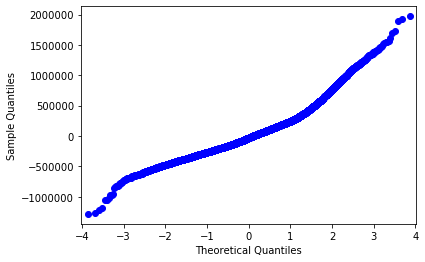

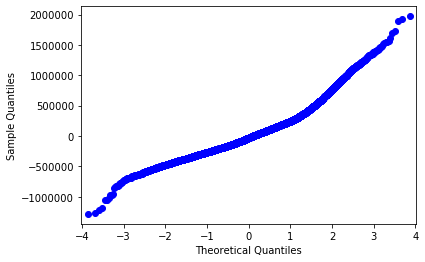

In [41]:
newsm_resids = newsm.resid
sm.qqplot(newsm_resids)

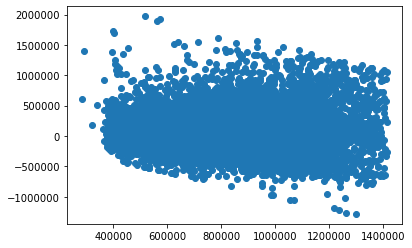

In [42]:
y_hat = newsm.predict()
plt.scatter(y_hat,newsm_resids)
plt.show()